In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# Any results you write to the current directory are saved as output.

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
import tensorflow as tf
from tensorflow import keras
from glob import glob
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


Using TensorFlow backend.


In [3]:
ham_path = '/kaggle/input/mnist1000-with-one-image-folder'
%cd $ham_path
%ls

image_path = ham_path + '/ham1000_images/HAM1000_images'
image_path

/kaggle/input/mnist1000-with-one-image-folder
HAM10000_metadata.csv  HAM1000_images/  ham1000_images/


'/kaggle/input/mnist1000-with-one-image-folder/ham1000_images/HAM1000_images'

In [4]:
# From https://www.kaggle.com/elvinj1203/resnet50-84-test-acc
data=pd.read_csv("/kaggle/input/mnist1000-with-one-image-folder/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()


In [5]:
rus = RandomUnderSampler(sampling_strategy='auto',
                    random_state=42)
X_downsampled, Y_downsampled = rus.fit_resample(X, Y)

In [6]:
Y_downsampled.dx.value_counts()

nv       115
df       115
bcc      115
akiec    115
bkl      115
mel      115
vasc     115
Name: dx, dtype: int64

In [11]:
X_train, X_test, y_train, y_test   = train_test_split(X_downsampled,Y_downsampled, test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.25, random_state=42)


train_downsampled = pd.concat([X_downsampled, Y_downsampled], axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [12]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# horizontal_flip=True to flip images randomly
image_generator = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

BATCH_SIZE = 32
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train_downsampled,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

Found 805 validated image filenames belonging to 7 classes.
Found 161 validated image filenames belonging to 7 classes.
Found 161 validated image filenames belonging to 7 classes.


In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def MobileNetV2_frozen(img_size=None):
  # Import the mobilenetV2 model and discards the last 1000 neuron layer.
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=img_size)
    print("Number of layers in the base model: ", len(base_model.layers))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
  # Dense = FullyConnected
    x = Dense(1024,activation='relu')(x) 
  # Final layer with softmax activation
    pred_layer = Dense(7, activation='softmax')(x) 

    model = Model(inputs=base_model.input,outputs=pred_layer)
    return model
  
model = MobileNetV2_frozen((128,128,3))
model.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

9412608/9406464 [==============================] - 1s 0us/step
Number of layers in the base model:  155
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]             

In [20]:
mobileNetV2_frozen_path = "mobileNetV2_frozen.ckpt"
mobileNetV2_frozen_dir = '/kaggle/working/' + mobileNetV2_frozen_path

mobileNetV2_trainable_path = "mobileNetV2_trainable.ckpt"
mobileNetV2_trainable_dir = '/kaggle/working/' + mobileNetV2_trainable_path

In [21]:
# This doesn't save weights for some reasons
saveCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=mobileNetV2_frozen_dir, 
    verbose=1, 
    save_weights_only=True,
    period=10)

saveCheckpointTrainable = tf.keras.callbacks.ModelCheckpoint(
    filepath=mobileNetV2_trainable_dir, 
    verbose=1, 
    save_weights_only=True,
    period=10)

In [16]:
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    precision = history.history['precision']
    val_precision = history.history['val_precision']

    recall = history.history['recall']
    val_recall = history.history['val_recall']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Precision')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Recall')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Train for 26 steps, validate for 6 steps
Epoch 1/10
26/26 [==============================] - 24s 930ms/step - loss: 1.7981 - tp: 206.0000 - fp: 217.0000 - tn: 4613.0000 - fn: 599.0000 - accuracy: 0.8552 - precision: 0.4870 - recall: 0.2559 - auc: 0.7495 - val_loss: 2.5273 - val_tp: 36.0000 - val_fp: 74.0000 - val_tn: 892.0000 - val_fn: 125.0000 - val_accuracy: 0.8234 - val_precision: 0.3273 - val_recall: 0.2236 - val_auc: 0.6011
Epoch 2/10
26/26 [==============================] - 15s 570ms/step - loss: 1.2505 - tp: 321.0000 - fp: 157.0000 - tn: 4673.0000 - fn: 484.0000 - accuracy: 0.8862 - precision: 0.6715 - recall: 0.3988 - auc: 0.8734 - val_loss: 2.9113 - val_tp: 35.0000 - val_fp: 102.0000 - val_tn: 864.0000 - val_fn: 126.0000 - val_accuracy: 0.7977 - val_precision: 0.2555 - val_recall: 0.2174 - val_auc: 0.5849
Epoch 3/10
26/26 [==============================] - 14s 556ms/step - loss: 1.1817 - tp: 360.0000 - fp: 174.0000 - tn: 4656.0000 - fn: 445.0000 - accuracy: 0.8902 - precision:

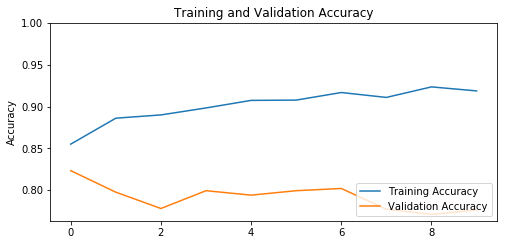

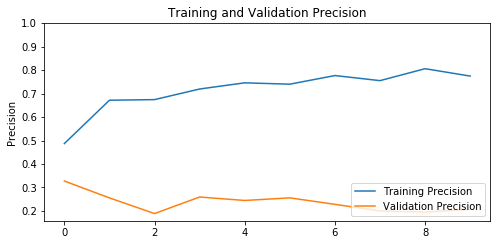

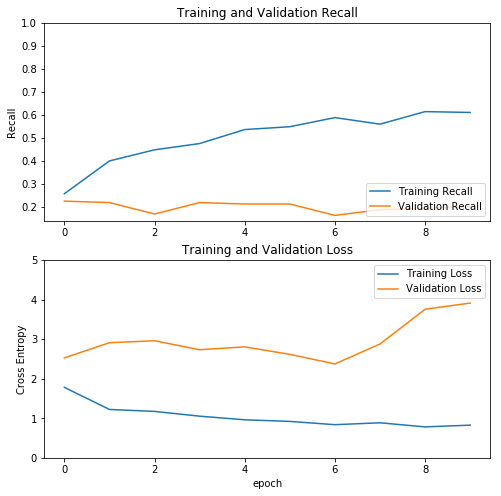

6/6 [==============================] - 2s 393ms/step - loss: 4.0146 - tp: 30.0000 - fp: 124.0000 - tn: 842.0000 - fn: 131.0000 - accuracy: 0.7737 - precision: 0.1948 - recall: 0.1863 - auc: 0.5753


[4.0146419405937195,
 30.0,
 124.0,
 842.0,
 131.0,
 0.7737355,
 0.19480519,
 0.1863354,
 0.5752961]

In [17]:
history10 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)
history_plot(history10)
model.evaluate(test_generator)

In [18]:
def MobileNetV2_trainable(img_size=None):
  # Import the mobilenetV2 model and discards the last 1000 neuron layer.
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=img_size)
    print("Number of layers in the base model: ", len(base_model.layers))
    #base_model.trainable = False
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
  # Dense = FullyConnected
    x = Dense(1024,activation='relu')(x) 
  # Final layer with softmax activation
    pred_layer = Dense(7, activation='softmax')(x) 

    model = Model(inputs=base_model.input,outputs=pred_layer)
    return model
  
model2 = MobileNetV2_trainable((128,128,3))
model2.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

model2.load_weights(mobileNetV2_frozen_dir)

Number of layers in the base model:  155
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
___________________________________________________

In [19]:
# Check that weights load properly
model2.evaluate(test_generator)

6/6 [==============================] - 4s 662ms/step - loss: 3.8391 - tp: 35.0000 - fp: 120.0000 - tn: 846.0000 - fn: 126.0000 - accuracy: 0.7817 - precision: 0.2258 - recall: 0.2174 - auc: 0.5821


[3.8390596906344094,
 35.0,
 120.0,
 846.0,
 126.0,
 0.7817213,
 0.22580644,
 0.2173913,
 0.582147]

Train for 26 steps, validate for 6 steps
Epoch 1/10
26/26 [==============================] - 19s 745ms/step - loss: 1.8241 - tp: 215.0000 - fp: 183.0000 - tn: 4647.0000 - fn: 590.0000 - accuracy: 0.8628 - precision: 0.5402 - recall: 0.2671 - auc: 0.7797 - val_loss: 8.1749 - val_tp: 19.0000 - val_fp: 142.0000 - val_tn: 824.0000 - val_fn: 142.0000 - val_accuracy: 0.7480 - val_precision: 0.1180 - val_recall: 0.1180 - val_auc: 0.4860
Epoch 2/10
26/26 [==============================] - 14s 545ms/step - loss: 1.2789 - tp: 280.0000 - fp: 143.0000 - tn: 4687.0000 - fn: 525.0000 - accuracy: 0.8815 - precision: 0.6619 - recall: 0.3478 - auc: 0.8702 - val_loss: 4.3412 - val_tp: 27.0000 - val_fp: 134.0000 - val_tn: 832.0000 - val_fn: 134.0000 - val_accuracy: 0.7622 - val_precision: 0.1677 - val_recall: 0.1677 - val_auc: 0.4845
Epoch 3/10
26/26 [==============================] - 14s 537ms/step - loss: 1.0780 - tp: 353.0000 - fp: 140.0000 - tn: 4690.0000 - fn: 452.0000 - accuracy: 0.8949 - precision

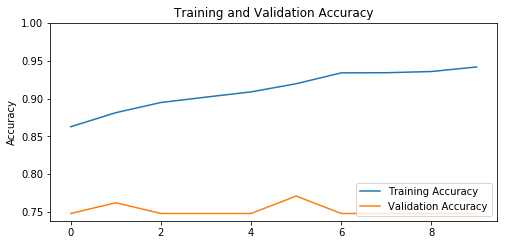

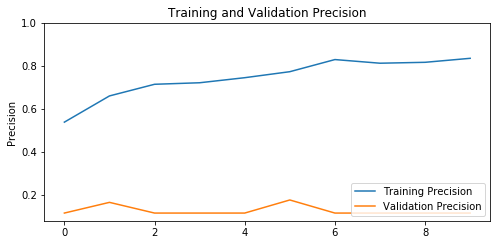

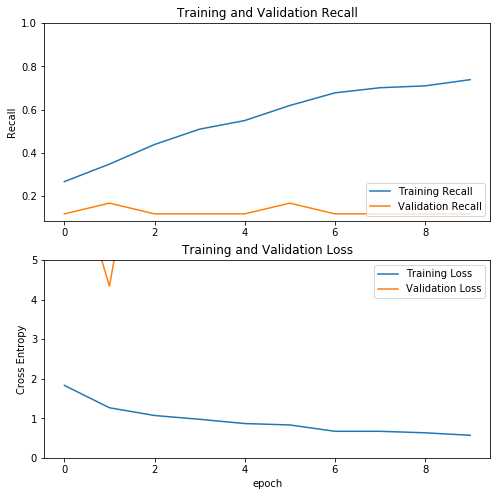

6/6 [==============================] - 2s 403ms/step - loss: 13.1640 - tp: 29.0000 - fp: 132.0000 - tn: 834.0000 - fn: 132.0000 - accuracy: 0.7657 - precision: 0.1801 - recall: 0.1801 - auc: 0.5244


[13.164023737103284,
 29.0,
 132.0,
 834.0,
 132.0,
 0.7657498,
 0.18012422,
 0.18012422,
 0.52444917]

In [22]:
# Unfrozen trainable
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpointTrainable]
)
history_plot(history2)
model2.evaluate(test_generator)

Train for 26 steps, validate for 6 steps
Epoch 1/10
26/26 [==============================] - 14s 540ms/step - loss: 0.7726 - tp: 499.0000 - fp: 134.0000 - tn: 4696.0000 - fn: 306.0000 - accuracy: 0.9219 - precision: 0.7883 - recall: 0.6199 - auc: 0.9484 - val_loss: 3.3116 - val_tp: 32.0000 - val_fp: 120.0000 - val_tn: 846.0000 - val_fn: 129.0000 - val_accuracy: 0.7791 - val_precision: 0.2105 - val_recall: 0.1988 - val_auc: 0.5940
Epoch 2/10
26/26 [==============================] - 15s 562ms/step - loss: 0.7195 - tp: 521.0000 - fp: 123.0000 - tn: 4707.0000 - fn: 284.0000 - accuracy: 0.9278 - precision: 0.8090 - recall: 0.6472 - auc: 0.9560 - val_loss: 3.6638 - val_tp: 38.0000 - val_fp: 117.0000 - val_tn: 849.0000 - val_fn: 123.0000 - val_accuracy: 0.7870 - val_precision: 0.2452 - val_recall: 0.2360 - val_auc: 0.5943
Epoch 3/10
26/26 [==============================] - 14s 541ms/step - loss: 0.7602 - tp: 532.0000 - fp: 135.0000 - tn: 4695.0000 - fn: 273.0000 - accuracy: 0.9276 - precision

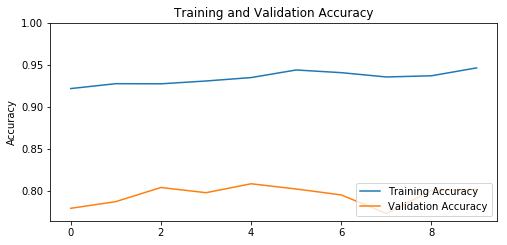

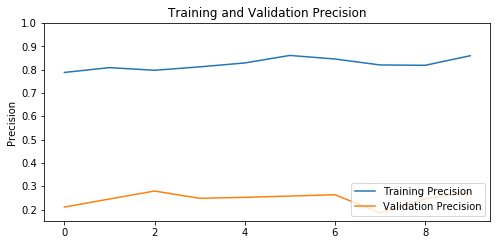

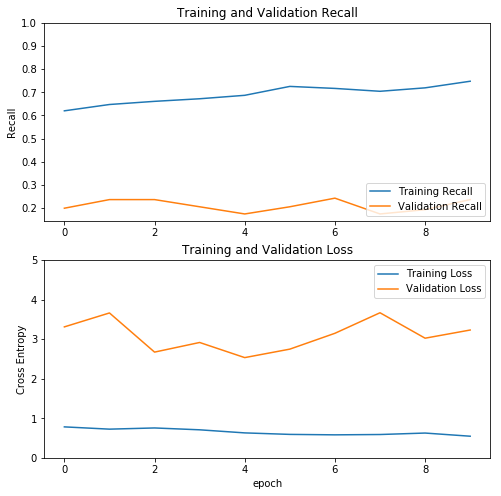

6/6 [==============================] - 2s 391ms/step - loss: 2.7529 - tp: 41.0000 - fp: 96.0000 - tn: 870.0000 - fn: 120.0000 - accuracy: 0.8083 - precision: 0.2993 - recall: 0.2547 - auc: 0.6407


[2.7528976698716483,
 41.0,
 96.0,
 870.0,
 120.0,
 0.8083407,
 0.29927006,
 0.25465837,
 0.6407096]

In [23]:
# Frozen to 20
history20 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)
history_plot(history20)
model.evaluate(test_generator)

Train for 26 steps, validate for 6 steps
Epoch 1/10
26/26 [==============================] - 14s 550ms/step - loss: 0.5392 - tp: 592.0000 - fp: 106.0000 - tn: 4724.0000 - fn: 213.0000 - accuracy: 0.9434 - precision: 0.8481 - recall: 0.7354 - auc: 0.9754 - val_loss: 3.1906 - val_tp: 40.0000 - val_fp: 104.0000 - val_tn: 862.0000 - val_fn: 121.0000 - val_accuracy: 0.8004 - val_precision: 0.2778 - val_recall: 0.2484 - val_auc: 0.6328
Epoch 2/10
26/26 [==============================] - 14s 543ms/step - loss: 0.5098 - tp: 618.0000 - fp: 103.0000 - tn: 4727.0000 - fn: 187.0000 - accuracy: 0.9485 - precision: 0.8571 - recall: 0.7677 - auc: 0.9778 - val_loss: 3.2017 - val_tp: 37.0000 - val_fp: 110.0000 - val_tn: 856.0000 - val_fn: 124.0000 - val_accuracy: 0.7924 - val_precision: 0.2517 - val_recall: 0.2298 - val_auc: 0.6237
Epoch 3/10
26/26 [==============================] - 14s 556ms/step - loss: 0.4724 - tp: 633.0000 - fp: 98.0000 - tn: 4732.0000 - fn: 172.0000 - accuracy: 0.9521 - precision:

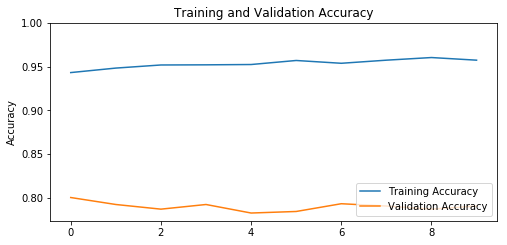

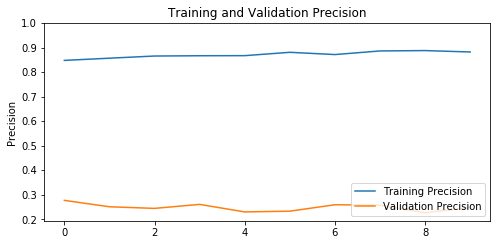

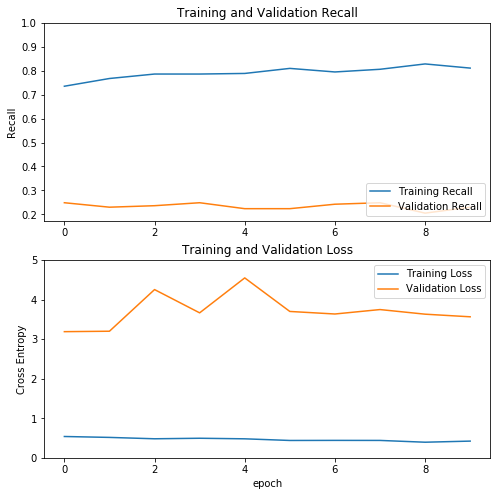

6/6 [==============================] - 2s 395ms/step - loss: 3.9362 - tp: 39.0000 - fp: 106.0000 - tn: 860.0000 - fn: 122.0000 - accuracy: 0.7977 - precision: 0.2690 - recall: 0.2422 - auc: 0.6070


[3.9362170696258545,
 39.0,
 106.0,
 860.0,
 122.0,
 0.797693,
 0.2689655,
 0.24223602,
 0.6069919]

In [24]:
# Frozen to 30
history30 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)
history_plot(history30)
model.evaluate(test_generator)

In [ ]:
# Frozen to 40
history40 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)
history_plot(history40)
model.evaluate(test_generator)

In [ ]:
history_plot(history3)

In [ ]:
# To 100 epochs?
history4 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=[saveCheckpoint]
)

In [ ]:
# 50 Epcohs --> Overfitting
model.evaluate(test_generator)

# 40 Epochs = Best for Frozen

# Imbalanced Dataset

In [26]:
# From https://www.kaggle.com/elvinj1203/resnet50-84-test-acc
data=pd.read_csv("/kaggle/input/mnist1000-with-one-image-folder/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.25, random_state=42)

train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [35]:
train.dx.value_counts()

nv       4050
mel       657
bkl       628
bcc       310
akiec     201
vasc       94
df         69
Name: dx, dtype: int64

In [36]:
val.dx.value_counts()

nv       1317
bkl       243
mel       230
bcc       111
akiec      57
vasc       27
df         18
Name: dx, dtype: int64

In [ ]:
test.dx.value_counts()

In [27]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# horizontal_flip=True to flip images randomly
image_generator = ImageDataGenerator(
    rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

Found 6009 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


Number of layers in the base model:  155
Train for 188 steps, validate for 63 steps
Epoch 1/10
188/188 [==============================] - 97s 517ms/step - loss: 0.8863 - tp: 3791.0000 - fp: 940.0000 - tn: 35114.0000 - fn: 2218.0000 - accuracy: 0.9249 - precision: 0.8013 - recall: 0.6309 - auc: 0.9376 - val_loss: 1.6182 - val_tp: 1318.0000 - val_fp: 682.0000 - val_tn: 11336.0000 - val_fn: 685.0000 - val_accuracy: 0.9025 - val_precision: 0.6590 - val_recall: 0.6580 - val_auc: 0.8711
Epoch 2/10
188/188 [==============================] - 92s 490ms/step - loss: 0.5226 - tp: 4541.0000 - fp: 734.0000 - tn: 35320.0000 - fn: 1468.0000 - accuracy: 0.9476 - precision: 0.8609 - recall: 0.7557 - auc: 0.9768 - val_loss: 1.7433 - val_tp: 1307.0000 - val_fp: 655.0000 - val_tn: 11363.0000 - val_fn: 696.0000 - val_accuracy: 0.9036 - val_precision: 0.6662 - val_recall: 0.6525 - val_auc: 0.8580
Epoch 3/10
188/188 [==============================] - 92s 488ms/step - loss: 0.3132 - tp: 5152.0000 - fp: 462.00

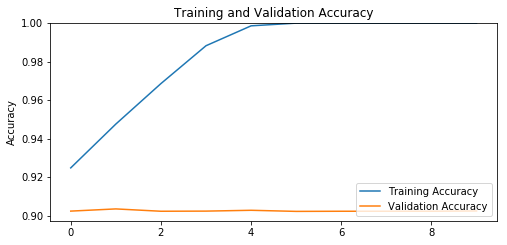

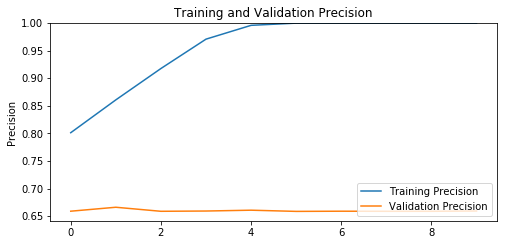

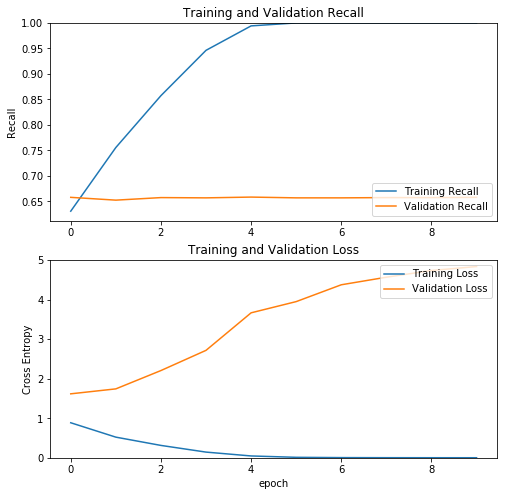

63/63 [==============================] - 29s 461ms/step - loss: 4.6320 - tp: 1336.0000 - fp: 665.0000 - tn: 11353.0000 - fn: 667.0000 - accuracy: 0.9050 - precision: 0.6677 - recall: 0.6670 - auc: 0.8158


[4.631951831635975,
 1336.0,
 665.0,
 11353.0,
 667.0,
 0.90499973,
 0.66766614,
 0.6669995,
 0.81575316]

In [32]:
model_im = MobileNetV2_frozen((128,128,3))

model_im.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)
# Imbalanced to 10
history_im = model_im.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)
history_plot(history_im)
model_im.evaluate(test_generator)